# Identify & Track Marine Heatwaves on _Unstructured Grid_ using `spot_the_blOb`

## Processing Steps:
1. Fill spatial holes in the binary data, using `dask_image.ndmorph` -- up to `R_fill` cells in radius.
2. Fill gaps in time -- permitting up to `T_fill` missing time slices, while keeping the same blob ID.
3. Filter out small objects -- area less than the bottom `area_filter_quartile` of the size distribution of objects.
4. Identify objects in the binary data, using `dask_image.ndmeasure`.
5. Connect objects across time, applying the following criteria for splitting, merging, and persistence:
    - Connected Blobs must overlap by at least fraction `overlap_threshold` of the smaller blob.
    - Merged Blobs retain their original ID, but partition the child blob based on the parent of the _nearest-neighbour_ cell. 
6. Cluster and reduce the final object ID graph using `scipy.sparse.csgraph.connected_components`.
7. Map the tracked objects into ID-time space for convenient analysis.

N.B.: Exploits parallelised `dask` operations with optimised chunking using `flox` for memory efficiency and speed \
N.N.B.: This example using 40 years of _daily_ outputs at 5km resolution on an Unstructured Grid (15 million cells) using 32 cores takes 
- Full Split/Merge Thresholding & Merge Tracking:  ~40 minutes

In [1]:
import xarray as xr
import dask
from getpass import getuser
from pathlib import Path

import spot_the_blOb as blob
import spot_the_blOb.helper as hpc

In [2]:
# Start Dask Cluster
client = hpc.StartLocalCluster(n_workers=32, n_threads=2)

Memory per Worker: 7.86 GB
Hostname is  l30146
Forward Port = l30146:8787
Dashboard Link: localhost:8787/status


In [3]:
# Load Pre-processed Data (cf. `01_preprocess_extremes.ipynb`)

file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'extreme_events_binary_unstruct.zarr'
chunk_size = {'time': 4, 'ncells': -1}
ds = xr.open_zarr(str(file_name), chunks={}).isel(time=slice(0,32)).chunk(chunk_size)

In [4]:
# Tracking Parameters

drop_area_quartile = 0.8  # Remove the smallest 80% of the identified blobs
hole_filling_radius = 32   # Fill small holes with radius < 8 elements
time_gap_fill = 2         # Allow gaps of 2 days and still continue the blob tracking with the same ID
allow_merging = True      # Allow blobs to split/merge. Keeps track of merge events & unique IDs.
overlap_threshold = 0.5   # Overlap threshold for merging blobs. If overlap < threshold, blobs keep independent IDs.
nn_partitioning = True    # Use new NN method to partition merged children blobs. If False, reverts to old method of Di Sun et al. 2023...

In [5]:
# SpOt & Track the Blobs & Merger Events

tracker = blob.Spotter(ds.extreme_events, ds.mask, R_fill=hole_filling_radius, T_fill = time_gap_fill, area_filter_quartile=drop_area_quartile, 
                       allow_merging=allow_merging, overlap_threshold=overlap_threshold, nn_partitioning=nn_partitioning, 
                       xdim='ncells',               # Need to tell spot_the_blOb the new Unstructured dimension
                       unstructured_grid=True,      # Use Unstructured Grid
                       neighbours=ds.neighbours,    # Connectivity array for the Unstructured Grid
                       cell_areas=ds.cell_areas)      # Cell areas for each Unstructured Grid cell
# blobs = tracker.run(return_merges=False)

# blobs

Constructing the Sparse Dilation Matrix...


In [6]:
import pyicon as pyic
import numpy as np

----Start loading pyicon.
----Start loading pyicon.
----Pyicon was loaded successfully.
----Pyicon was loaded successfully.


In [7]:
data_bin_filled = tracker.fill_holes(tracker.data_bin).persist()
data_bin_gap_filled = tracker.fill_time_gaps(data_bin_filled).persist()
data_bin_filtered, area_threshold, blob_areas, N_blobs_unfiltered = tracker.filter_small_blobs(data_bin_gap_filled)
data_bin_filtered = data_bin_filtered.persist()

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 680.62 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 680.66 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home/b/b382615/opt/spot_the_blOb/spot_the_blOb/spot_the_blOb.py:690: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` pa

2025-01-28 15:10:17,059 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('original-invert-8fd951b7d4123bc599e52d80b0b2ed21', 0) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: processing
old run_spec: <Task ('original-invert-8fd951b7d4123bc599e52d80b0b2ed21', 0) _execute_subgraph(...)>
new run_spec: <Task ('original-invert-8fd951b7d4123bc599e52d80b0b2ed21', 0) _execute_subgraph(...)>
old token: '7eec8596250204a1a87d272be16481d5'
new token: '0b831487e36fa32d5926fc602ca88e1f'
old dependencies: set()
new dependencies: set()

2025-01-28 15:10:17,140 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('

In [8]:
#### Track_blObs....

blob_id_field, _ = tracker.identify_blobs(data_bin_filtered, time_connectivity=False)
blob_id_field = blob_id_field.persist()

cumsum_ids = (blob_id_field.max(dim=tracker.xdim)).cumsum(tracker.timedim).shift({tracker.timedim: 1}, fill_value=0)
blob_id_field = xr.where(blob_id_field > 0, blob_id_field + cumsum_ids, 0)

blob_props = tracker.calculate_blob_properties(blob_id_field, properties=['area', 'centroid'])

/home/b/b382615/opt/spot_the_blOb/spot_the_blOb/spot_the_blOb.py:587: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  props_array = xr.apply_ufunc(blob_properties_chunk, blob_id_field,


In [9]:
import xarray as xr
import numpy as np
from dask_image.ndmeasure import label
from skimage.measure import regionprops_table
from dask_image.ndmorph import binary_closing as binary_closing_dask
from dask_image.ndmorph import binary_opening as binary_opening_dask
from scipy.ndimage import binary_closing, binary_opening
from scipy.sparse import coo_matrix, csr_matrix, eye
from scipy.sparse.csgraph import connected_components
from dask import persist
from dask import delayed
from dask import compute as dask_compute
import dask.array as dsa
from dask.base import is_dask_collection
from numba import jit, njit, int64, int32, prange
import jax.numpy as jnp
import warnings

In [10]:
blob_id_field_unique = blob_id_field

In [11]:


##################################
### Optimised Helper Functions ###
##################################


@jit(nopython=True, parallel=True, fastmath=True)
def wrapped_euclidian_parallel(mask_values, parent_centroids_values, Nx):
    """
    Optimised function for computing wrapped Euclidean distances.
    
    Parameters:
    -----------
    mask_values : np.ndarray
        2D boolean array where True indicates points to calculate distances for
    parent_centroids_values : np.ndarray
        Array of shape (n_parents, 2) containing (y, x) coordinates of parent centroids
    Nx : int
        Size of the x-dimension for wrapping
        
    Returns:
    --------
    distances : np.ndarray
        Array of shape (n_true_points, n_parents) with minimum distances
    """
    n_parents = len(parent_centroids_values)
    half_Nx = Nx / 2
    
    y_indices, x_indices = np.nonzero(mask_values)
    n_true = len(y_indices)
    
    distances = np.empty((n_true, n_parents), dtype=np.float64)
    
    # Precompute for faster access
    parent_y = parent_centroids_values[:, 0]
    parent_x = parent_centroids_values[:, 1]
    
    # Parallel loop over true positions
    for idx in prange(n_true):
        y, x = y_indices[idx], x_indices[idx]
        
        # Pre-compute y differences for all parents
        dy = y - parent_y
        
        # Pre-compute x differences for all parents
        dx = x - parent_x
        
        # Wrapping correction
        dx = np.where(dx > half_Nx, dx - Nx, dx)
        dx = np.where(dx < -half_Nx, dx + Nx, dx)
        
        distances[idx] = np.sqrt(dy * dy + dx * dx)
    
    return distances



@jit(nopython=True, fastmath=True)
def create_grid_index_arrays(points_y, points_x, grid_size, ny, nx):
    """
    Creates a grid-based spatial index using numpy arrays.
    """
    n_grids_y = (ny + grid_size - 1) // grid_size
    n_grids_x = (nx + grid_size - 1) // grid_size
    max_points_per_cell = len(points_y)
    
    grid_points = np.full((n_grids_y, n_grids_x, max_points_per_cell), -1, dtype=np.int32)
    grid_counts = np.zeros((n_grids_y, n_grids_x), dtype=np.int32)
    
    for idx in range(len(points_y)):
        grid_y = min(points_y[idx] // grid_size, n_grids_y - 1)
        grid_x = min(points_x[idx] // grid_size, n_grids_x - 1)
        count = grid_counts[grid_y, grid_x]
        if count < max_points_per_cell:
            grid_points[grid_y, grid_x, count] = idx
            grid_counts[grid_y, grid_x] += 1
    
    return grid_points, grid_counts

@jit(nopython=True, fastmath=True)
def calculate_wrapped_distance(y1, x1, y2, x2, nx, half_nx):
    """
    Calculate distance with periodic boundary conditions in x dimension.
    """
    dy = y1 - y2
    dx = x1 - x2
    
    if dx > half_nx:
        dx -= nx
    elif dx < -half_nx:
        dx += nx
        
    return np.sqrt(dy * dy + dx * dx)

@jit(nopython=True, parallel=True, fastmath=True)
def get_nearest_parent_labels(child_mask, parent_masks, child_ids, parent_centroids, Nx, max_distance=20):
    """
    Assigns labels based on nearest parent blob points.
    This is quite computationally-intensive, so we utilise many optimisations here...
    """
    
    ny, nx = child_mask.shape
    half_Nx = Nx / 2
    n_parents = len(parent_masks)
    grid_size = max(2, max_distance // 4)
    
    y_indices, x_indices = np.nonzero(child_mask)
    n_child_points = len(y_indices)
    
    min_distances = np.full(n_child_points, np.inf)
    parent_assignments = np.zeros(n_child_points, dtype=np.int32)
    found_close = np.zeros(n_child_points, dtype=np.bool_)
    
    for parent_idx in range(n_parents):
        py, px = np.nonzero(parent_masks[parent_idx])
        
        if len(py) == 0:  # Skip empty parents
            continue
            
        # Create grid index for this parent
        n_grids_y = (ny + grid_size - 1) // grid_size
        n_grids_x = (nx + grid_size - 1) // grid_size
        grid_points, grid_counts = create_grid_index_arrays(py, px, grid_size, ny, nx)
        
        # Process child points in parallel
        for child_idx in prange(n_child_points):
            if found_close[child_idx]:  # Skip if we already found an exact match
                continue
                
            child_y, child_x = y_indices[child_idx], x_indices[child_idx]
            grid_y = min(child_y // grid_size, n_grids_y - 1)
            grid_x = min(child_x // grid_size, n_grids_x - 1)
            
            min_dist_to_parent = np.inf
            
            # Check nearby grid cells
            for dy in range(-1, 2):
                grid_y_check = (grid_y + dy) % n_grids_y
                
                for dx in range(-1, 2):
                    grid_x_check = (grid_x + dx) % n_grids_x
                    
                    # Process points in this grid cell
                    n_points = grid_counts[grid_y_check, grid_x_check]
                    
                    for p_idx in range(n_points):
                        point_idx = grid_points[grid_y_check, grid_x_check, p_idx]
                        if point_idx == -1:
                            break
                        
                        dist = calculate_wrapped_distance(
                            child_y, child_x,
                            py[point_idx], px[point_idx],
                            Nx, half_Nx
                        )
                        
                        if dist > max_distance:
                            continue
                        
                        if dist < min_dist_to_parent:
                            min_dist_to_parent = dist
                            
                        if dist < 1e-6:  # Found exact same point (within numerical precision)
                            min_dist_to_parent = dist
                            found_close[child_idx] = True
                            break
                    
                    if found_close[child_idx]:
                        break
                
                if found_close[child_idx]:
                    break
            
            # Update assignment if this parent is closer
            if min_dist_to_parent < min_distances[child_idx]:
                min_distances[child_idx] = min_dist_to_parent
                parent_assignments[child_idx] = parent_idx
    
    # Handle any unassigned points using centroids
    unassigned = min_distances == np.inf
    if np.any(unassigned):
        for child_idx in np.nonzero(unassigned)[0]:
            child_y, child_x = y_indices[child_idx], x_indices[child_idx]
            min_dist = np.inf
            best_parent = 0
            
            for parent_idx in range(n_parents):
                # Calculate distance to centroid with periodic boundary conditions
                dist = calculate_wrapped_distance(
                    child_y, child_x,
                    parent_centroids[parent_idx, 0],
                    parent_centroids[parent_idx, 1],
                    Nx, half_Nx
                )
                
                if dist < min_dist:
                    min_dist = dist
                    best_parent = parent_idx
                    
            parent_assignments[child_idx] = best_parent
    
    # Convert from parent indices to child_ids
    new_labels = child_ids[parent_assignments]
    
    return new_labels

@jit(nopython=True, fastmath=True)
def get_nearest_parent_labels_unstructured(child_mask, parent_masks, child_ids, parent_centroids, neighbours_int, lat, lon, max_distance=20):
    """
    Optimized version of nearest parent label assignment for unstructured grids.
    Uses numpy arrays throughout to ensure Numba compatibility.
    
    Parameters
    ----------
    child_mask : np.ndarray
        1D boolean array where True indicates points in the child blob
    parent_masks : np.ndarray
        2D boolean array of shape (n_parents, n_points) where True indicates points in each parent blob
    child_ids : np.ndarray
        1D array containing the IDs to assign to each partition of the child blob
    parent_centroids : np.ndarray
        Array of shape (n_parents, 2) containing (lat, lon) coordinates of parent centroids in degrees
    neighbours_int : np.ndarray
        2D array of shape (3, n_points) containing indices of neighboring cells for each point
    lat / lon : np.ndarray
        Latitude/Longitude in degrees
    max_distance : int, optional
        Maximum number of edge hops to search for parent points
    
    Returns
    -------
    new_labels : np.ndarray
        1D array containing the assigned child_ids for each True point in child_mask
    """
    n_points = len(child_mask)
    n_parents = len(parent_masks)
    
    # Pre-allocate arrays
    distances = np.full(n_points, np.inf, dtype=np.float32)
    parent_assignments = np.full(n_points, -1, dtype=np.int32)
    visited = np.zeros((n_parents, n_points), dtype=np.bool_)
    
    # Initialize with direct overlaps
    for parent_idx in range(n_parents):
        overlap_mask = parent_masks[parent_idx] & child_mask
        if np.any(overlap_mask):
            visited[parent_idx, overlap_mask] = True
            unclaimed_overlap = distances[overlap_mask] == np.inf
            if np.any(unclaimed_overlap):
                overlap_points = np.where(overlap_mask)[0]
                valid_points = overlap_points[unclaimed_overlap]
                distances[valid_points] = 0
                parent_assignments[valid_points] = parent_idx
    
    # Pre-compute trig values
    lat_rad = np.deg2rad(lat)
    lon_rad = np.deg2rad(lon)
    cos_lat = np.cos(lat_rad)
    
    # Graph traversal for remaining points
    current_distance = 0
    any_unassigned = np.any(child_mask & (parent_assignments == -1))
    
    while current_distance < max_distance and any_unassigned:
        current_distance += 1
        updates_made = False
        
        for parent_idx in range(n_parents):
            # Get current frontier points
            frontier_mask = visited[parent_idx]
            if not np.any(frontier_mask):
                continue
            
            # Process neighbors
            for i in range(3):  # For each neighbor direction
                neighbors = neighbours_int[i, frontier_mask]
                valid_neighbors = neighbors >= 0
                if not np.any(valid_neighbors):
                    continue
                    
                valid_points = neighbors[valid_neighbors]
                unvisited = ~visited[parent_idx, valid_points]
                new_points = valid_points[unvisited]
                
                if len(new_points) > 0:
                    visited[parent_idx, new_points] = True
                    update_mask = distances[new_points] > current_distance
                    if np.any(update_mask):
                        points_to_update = new_points[update_mask]
                        distances[points_to_update] = current_distance
                        parent_assignments[points_to_update] = parent_idx
                        updates_made = True
        
        if not updates_made:
            break
            
        any_unassigned = np.any(child_mask & (parent_assignments == -1))
    
    # Handle remaining unassigned points using great circle distances
    unassigned_mask = child_mask & (parent_assignments == -1)
    if np.any(unassigned_mask):
        parent_lat_rad = np.deg2rad(parent_centroids[:, 0])
        parent_lon_rad = np.deg2rad(parent_centroids[:, 1])
        cos_parent_lat = np.cos(parent_lat_rad)
        
        unassigned_points = np.where(unassigned_mask)[0]
        for point in unassigned_points:
            # Vectorized haversine calculation
            dlat = parent_lat_rad - lat_rad[point]
            dlon = parent_lon_rad - lon_rad[point]
            a = np.sin(dlat/2)**2 + cos_lat[point] * cos_parent_lat * np.sin(dlon/2)**2
            dist = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
            parent_assignments[point] = np.argmin(dist)
    
    # Return only the assignments for points in child_mask
    child_points = np.where(child_mask)[0]
    return child_ids[parent_assignments[child_points]]


@jit(nopython=True, parallel=True, fastmath=True)
def unstructured_centroid_partition(child_mask, parent_centroids, child_ids, lat, lon):
    """
    Assigns labels to child cells based on closest parent centroid using great circle distances.
    
    Parameters:
    -----------
    child_mask : np.ndarray
        1D boolean array indicating which cells belong to the child blob
    parent_centroids : np.ndarray
        Array of shape (n_parents, 2) containing (lat, lon) coordinates of parent centroids in degrees
    child_ids : np.ndarray
        Array of IDs to assign to each partition of the child blob
    lat / lon : np.ndarray
        Latitude/Longitude in degrees
        
    Returns:
    --------
    new_labels : np.ndarray
        1D array containing assigned child_ids for cells in child_mask
    """
    n_cells = len(child_mask)
    n_parents = len(parent_centroids)
    
    lat_rad = np.deg2rad(lat)
    lon_rad = np.deg2rad(lon)
    parent_coords_rad = np.deg2rad(parent_centroids)
    
    new_labels = np.zeros(n_cells, dtype=child_ids.dtype)
    
    # Process each child cell in parallel
    for i in prange(n_cells):
        if not child_mask[i]:
            continue
            
        min_dist = np.inf
        closest_parent = 0
        
        # Calculate great circle distance to each parent centroid
        for j in range(n_parents):
            dlat = parent_coords_rad[j, 0] - lat_rad[i]
            dlon = parent_coords_rad[j, 1] - lon_rad[i]
            
            # Use haversine formula for great circle distance
            a = np.sin(dlat/2)**2 + np.cos(lat_rad[i]) * np.cos(parent_coords_rad[j, 0]) * np.sin(dlon/2)**2
            dist = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
            
            if dist < min_dist:
                min_dist = dist
                closest_parent = j
        
        new_labels[i] = child_ids[closest_parent]
    
    return new_labels





## Helper Function for Super Fast Sparse Bool Multiply (*without the scipy+Dask Memory Leak*)
@njit(fastmath=True, parallel=True)
def sparse_bool_power(vec, sp_data, indices, indptr, exponent):
    vec = vec.T
    num_rows = indptr.size - 1
    num_cols = vec.shape[1]
    result = vec.copy()

    for _ in range(exponent):
        temp_result = np.zeros((num_rows, num_cols), dtype=np.bool_)

        for i in prange(num_rows):
            for j in range(indptr[i], indptr[i + 1]):
                if sp_data[j]:
                    for k in range(num_cols):
                        if result[indices[j], k]:
                            temp_result[i, k] = True

        result = temp_result

    return result.T

In [12]:
overlap_blobs_list = tracker.find_overlapping_blobs(blob_id_field_unique, blob_props)  # List blob pairs that overlap by at least overlap_threshold percent
print('Finished finding overlapping blobs.')


## Initialise merge tracking lists to build DataArray later
merge_times = []       # When the merge occurred
merge_child_ids = []   # Resulting child ID
merge_parent_ids = []  # List of parent IDs that merged
merge_areas = []       # Areas of overlap

# Find initial merging blobs
unique_children, children_counts = np.unique(overlap_blobs_list[:, 1], return_counts=True)
merging_blobs = set(unique_children[children_counts > 1])


@delayed
def process_chunk(chunk_start, chunk_end, chunk_data, chunk_blobs, blob_time_idxs, previous_last_timeslice, next_id_start):
    '''Process a single chunk of merging blobs.
    blob_time_idxs :
        The time index of each blob in the chunk_blobs
    '''

    # Initialise tracking variables for this chunk
    chunk_merge_times = []
    chunk_merge_child_ids = []
    chunk_merge_parent_ids = []
    chunk_merge_areas = []
    next_new_id = next_id_start
    new_merging_blobs = set()
    id_mapping = {}  # Track local to global ID mapping
    
    
    # Process each blob in the chunk
    blobs_to_process = chunk_blobs.copy()
    child_time_idxs = blob_time_idxs.copy()
    loaded_time_idx = -1         
    while blobs_to_process:
        child_id = blobs_to_process.pop(0)
        child_time_idx = child_time_idxs.pop(0)
        relative_time_idx = child_time_idx - chunk_start
        
        # Load relative time slices, if they're not already loaded for this time
        if relative_time_idx != loaded_time_idx:
            loaded_time_idx = relative_time_idx
            
            blob_id_time = chunk_data.isel({tracker.timedim: relative_time_idx})
            if relative_time_idx + 1 < chunk_data.sizes[tracker.timedim]:
                blob_id_time_p1 = chunk_data.isel({tracker.timedim: relative_time_idx + 1})
            else:
                blob_id_time_p1 = xr.full_like(blob_id_time, 0)
                
            if relative_time_idx - 1 >= 0:
                blob_id_time_m1 = chunk_data.isel({tracker.timedim: relative_time_idx - 1})
            elif previous_last_timeslice is not None:
                blob_id_time_m1 = previous_last_timeslice
            else:
                blob_id_time_m1 = xr.full_like(blob_id_time, 0)
        
        # Compute local blob_props
        blob_props_local = xr.merge([
            tracker.calculate_blob_properties(blob_id_time, properties=['area', 'centroid'], full_array=False), 
            tracker.calculate_blob_properties(blob_id_time_m1, properties=['area', 'centroid'], full_array=False)
        ])
        
        # Compute local overlap blobs list & enforce minimum overlap
        overlap_blobs_local = tracker.check_overlap_slice_threshold(blob_id_time_m1.values, blob_id_time.values, blob_props_local)
        
        # Process merging logic
        child_mask_2d = (blob_id_time == child_id).values
        child_mask = overlap_blobs_local[:, 1] == child_id
        merge_group = overlap_blobs_local[child_mask]
        parent_ids = merge_group[:, 0]
        
        # Create parent masks and get centroids
        parent_masks = np.array([(blob_id_time_m1 == pid).values for pid in parent_ids])
        parent_centroids = blob_props_local.sel(ID=parent_ids).centroid.values
        child_ids = np.concatenate((np.array([child_id]), 
                                np.arange(next_new_id, next_new_id + (len(parent_ids) - 1), dtype=np.int32)))
        
        # Update ID tracking
        for new_id in child_ids[1:]:
            id_mapping[new_id] = None  # Will be assigned global ID later
        next_new_id += len(parent_ids) - 1
        
        # Partition child blob based on method
        if tracker.nn_partitioning:
            
            max_area = np.max(blob_props_local.sel(ID=parent_ids).area.values) / tracker.mean_cell_area
            max_distance = int(np.sqrt(max_area) * 2.0)  # Use 2x the max blob radius
            
            if tracker.unstructured_grid:
                new_labels = get_nearest_parent_labels_unstructured(
                    child_mask_2d.astype(np.bool_),
                    parent_masks.astype(np.bool_),
                    child_ids.astype(np.int32),
                    parent_centroids.astype(np.float64),
                    tracker.neighbours_int.values.astype(np.int32),
                    tracker.data_bin.lat.values.astype(np.float64),
                    tracker.data_bin.lon.values.astype(np.float64),
                    max_distance=max(max_distance, 20)*2  # Set minimum threshold, in cells
                )
            else:
                new_labels = get_nearest_parent_labels(
                    child_mask_2d.astype(np.bool_),
                    parent_masks.astype(np.bool_),
                    child_ids.astype(np.int32),
                    parent_centroids.astype(np.float64),
                    tracker.data_bin[tracker.xdim].size,
                    max_distance=max(max_distance, 20)  # Set minimum threshold, in pixels
                )
        else:
            if tracker.unstructured_grid:
                new_labels = unstructured_centroid_partition(
                    child_mask_2d,
                    parent_centroids,
                    child_ids,
                    tracker.data_bin.lat.values,
                    tracker.data_bin.lon.values
                )
            else:
                distances = wrapped_euclidian_parallel(child_mask_2d, parent_centroids, tracker.data_bin[tracker.xdim].size)
                new_labels = child_ids[np.argmin(distances, axis=1)]
        
        # Update chunk data
        temp = np.zeros_like(blob_id_time)
        temp[child_mask_2d] = new_labels
        blob_id_time = blob_id_time.where(~child_mask_2d, temp)
        chunk_data[{tracker.timedim: relative_time_idx}] = blob_id_time
        
        # Update tracking
        chunk_merge_times.append(chunk_data.isel({tracker.timedim: relative_time_idx}).time.values)
        chunk_merge_child_ids.append(child_ids)
        chunk_merge_parent_ids.append(parent_ids)
        chunk_merge_areas.append(merge_group[:, 2])
        
        # Update blob_props_local
        blob_props_local = xr.merge([
            tracker.calculate_blob_properties(blob_id_time, properties=['area', 'centroid'], full_array=False), 
            tracker.calculate_blob_properties(blob_id_time_p1, properties=['area', 'centroid'], full_array=False)
        ])
        
        # Check for new merging blobs
        overlap_blobs_local = tracker.check_overlap_slice_threshold(blob_id_time.values, blob_id_time_p1.values, blob_props_local)
        if len(overlap_blobs_local) > 0:
            new_unique_children, new_children_counts = np.unique(overlap_blobs_local[:, 1], return_counts=True)
            current_new_merging = set(new_unique_children[new_children_counts > 1])
            
            # Add to overall set of new merging blobs for this chunk
            new_merging_blobs.update(current_new_merging)
            
            # Add to processing queue if they're in the next timeslice of this chunk
            if relative_time_idx + 1 < chunk_data.sizes[tracker.timedim] - 1:
                for new_blob_id in current_new_merging:
                    if new_blob_id not in blobs_to_process:  # Avoid duplicates
                        blobs_to_process.append(new_blob_id)
                        
                        # Append to child_time_idxs (as the current child_time_idx+1)
                        child_time_idxs.append(child_time_idx + 1)

                        # Sort blobs_to_process (and child_time_idxs) by child_time_idxs
                        blobs_to_process = [b for _, b in sorted(zip(child_time_idxs, blobs_to_process))]
                        child_time_idxs = sorted(child_time_idxs)
    
    
    return (chunk_data[:(chunk_end-1-chunk_start)], next_new_id, new_merging_blobs,
            (chunk_merge_times, chunk_merge_child_ids, chunk_merge_parent_ids, chunk_merge_areas),
            id_mapping)

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 340.36 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Finished finding overlapping blobs.


In [13]:
## Process chunks iteratively until no new merging blobs remain
iteration = 0
max_iterations = 10
processed_chunks = set()
global_id_counter = blob_props.ID.max().item() + 1

In [14]:
### while..... vvv

In [39]:
blob_id_field_unique = blob_id_field_unique.persist()

# Pre-compute the child_time_idx for merging_blobs
time_index_map = tracker.compute_id_time_dict(blob_id_field_unique, list(merging_blobs), global_id_counter)

# Group blobs by time-chunk
chunk_boundaries = np.cumsum([0] + list(blob_id_field_unique.chunks[0]))
blobs_by_chunk = {}
for chunk_idx in range(len(blob_id_field_unique.chunks[0])):
    blobs_by_chunk[chunk_idx] = []

for blob_id in merging_blobs:
    chunk_idx = np.searchsorted(chunk_boundaries, time_index_map[blob_id], side='right') - 1
    blobs_by_chunk[chunk_idx].append(blob_id)


# Compute all chunks in parallel
chunk_futures = []
next_id_offset = 0
previous_last_timeslice = None

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 2.22 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [40]:
timeslices = blob_id_field_unique.isel({tracker.timedim: chunk_boundaries[1:-1]-1}).persist()
for chunk_idx in sorted(blobs_by_chunk.keys()):
    chunk_blobs = [b for b in merging_blobs if chunk_idx == np.searchsorted(chunk_boundaries, time_index_map[b], side='right') - 1]
    if not chunk_blobs:
        continue
    
    chunk_start = chunk_boundaries[chunk_idx]
    chunk_end = chunk_boundaries[chunk_idx + 1] + 1
    chunk_data = blob_id_field_unique.isel({tracker.timedim: slice(chunk_start, chunk_end)})
    
    previous_last_timeslice = timeslices[chunk_idx-1] if chunk_idx > 0 else None
    
    blob_time_idxs = [time_index_map[b] for b in chunk_blobs]
                        
    future = delayed(process_chunk)(chunk_start, chunk_end, chunk_data, chunk_blobs, blob_time_idxs, previous_last_timeslice,
                                global_id_counter + next_id_offset)
    chunk_futures.append((chunk_idx, future))
    chunk_size = blob_id_field_unique.chunks[0][chunk_idx]
    next_id_offset += len(chunk_blobs) * chunk_size  # Conservative estimate
    
results = dask_compute(*[f[1] for f in chunk_futures])

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 340.33 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [41]:
### Consolidate Data ###

# Consolidate Data: 1: Collect all temporary IDs and create global mapping
all_temp_ids = set()
for _, (_, _, _, _, id_mapping) in zip(chunk_futures, results):
    all_temp_ids.update(id_mapping.keys())

global_id_mapping = {temp_id: global_id_counter + i 
                for i, temp_id in enumerate(sorted(all_temp_ids))}
global_id_counter += len(all_temp_ids)

# Consolidate Data: 2: Process results and update global state
new_merging_blobs = set()

for (chunk_idx, _), (chunk_data, _, chunk_new_merging, chunk_merge_events, id_mapping) in zip(chunk_futures, results):
    # Update IDs in chunk data
    for temp_id, global_id in global_id_mapping.items():
        chunk_data = xr.where(chunk_data == temp_id, global_id, chunk_data)
    
    # Update chunk in main array
    chunk_start = chunk_boundaries[chunk_idx]
    chunk_end = chunk_boundaries[chunk_idx + 1]
    blob_id_field_unique[{tracker.timedim: slice(chunk_start, chunk_end)}] = chunk_data
    
    # Update merge events with new global IDs
    times, child_ids, parent_ids, areas = chunk_merge_events
    updated_child_ids = []
    for ids in child_ids:
        updated_ids = np.array([global_id_mapping.get(id_, id_) for id_ in ids])
        updated_child_ids.append(updated_ids)
    updated_parent_ids = []
    for ids in parent_ids:
        updated_ids = np.array([global_id_mapping.get(id_, id_) for id_ in ids])
        updated_parent_ids.append(updated_ids)
    
    merge_times.extend(times)
    merge_child_ids.extend(updated_child_ids)
    merge_parent_ids.extend(updated_parent_ids)
    merge_areas.extend(areas)
    
    # Track new merging blobs (using updated global IDs)
    new_merging_blobs.update(
        global_id_mapping.get(blob_id, blob_id) 
        for blob_id in chunk_new_merging
    )


# Prepare for next iteration
merging_blobs = new_merging_blobs - processed_chunks
processed_chunks.update(new_merging_blobs)
iteration += 1

In [43]:
merging_blobs

set()

In [42]:
blobs_by_chunk

{0: [],
 1: [],
 2: [],
 3: [149.0],
 4: [],
 5: [],
 6: [263.0, 272.0],
 7: [324.0, 303.0, 343.0]}

In [20]:
chunk_boundaries

array([ 0,  4,  8, 12, 16, 20, 24, 28, 32])

In [21]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(np.random.random(size=(200, 3)))

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 454.30 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(<GeoAxes: title={'right': '2002-05-01T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff6c862ab60>])

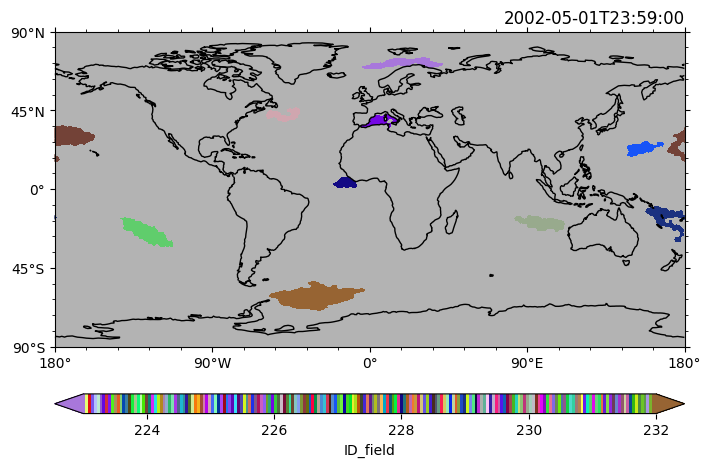

In [22]:
blob_id_field_unique.isel(time=20).pyic.plot(cmap=cmap)

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 454.30 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(<GeoAxes: title={'right': '2002-05-02T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff6b576b700>])

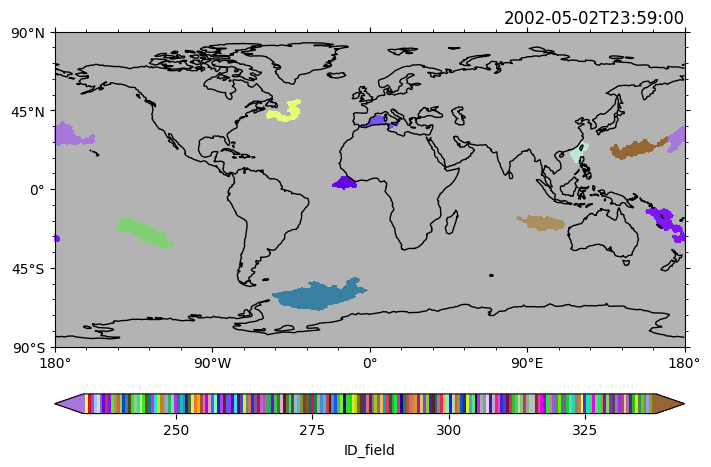

In [34]:
blob_id_field_unique.isel(time=21).pyic.plot(cmap=cmap)

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 454.30 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(<GeoAxes: title={'right': '2002-05-03T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff6c83877f0>])

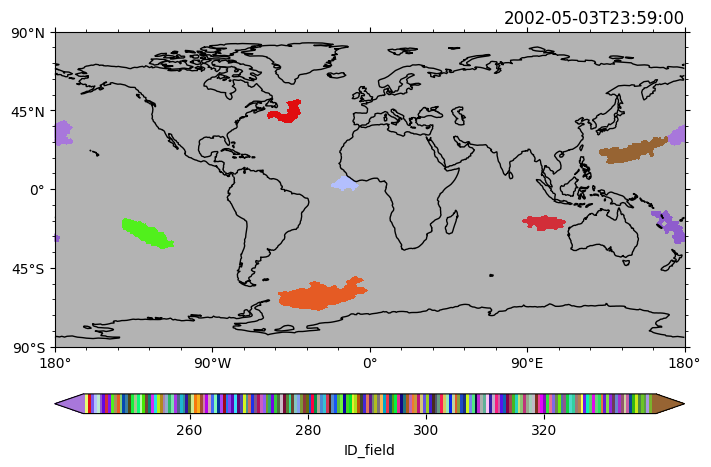

In [24]:
blob_id_field_unique.isel(time=22).pyic.plot(cmap=cmap)

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 454.30 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(<GeoAxes: title={'right': '2002-05-04T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff6b451fc70>])

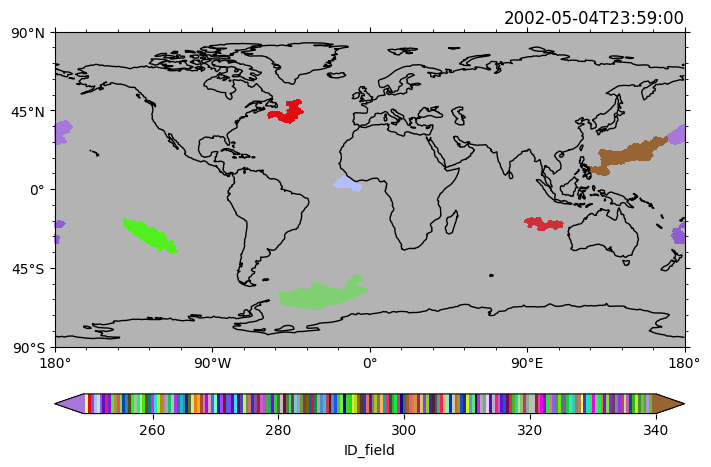

In [35]:
blob_id_field_unique.isel(time=23).pyic.plot(cmap=cmap)

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 454.30 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(<GeoAxes: title={'right': '2002-05-05T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff6b45994e0>])

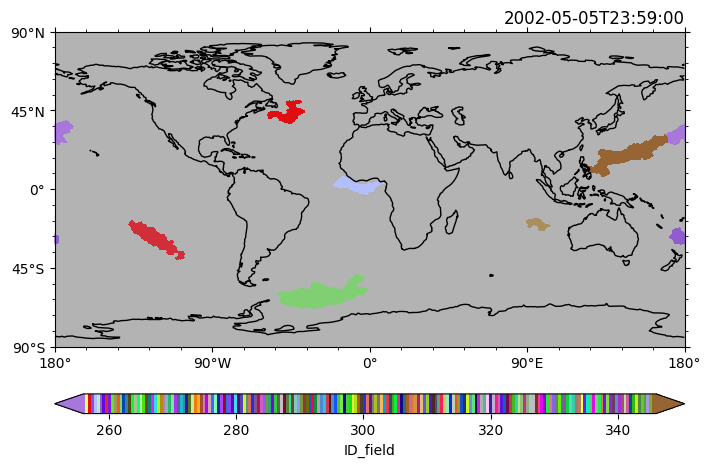

In [36]:
blob_id_field_unique.isel(time=24).pyic.plot(cmap=cmap)

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 454.30 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(<GeoAxes: title={'right': '2002-05-06T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff6b4224b20>])

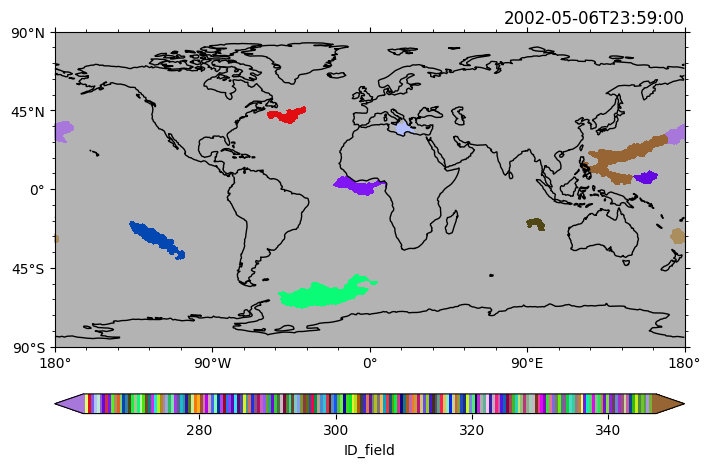

In [37]:
blob_id_field_unique.isel(time=25).pyic.plot(cmap=cmap)

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 454.30 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(<GeoAxes: title={'right': '2002-05-07T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff6ca892cb0>])

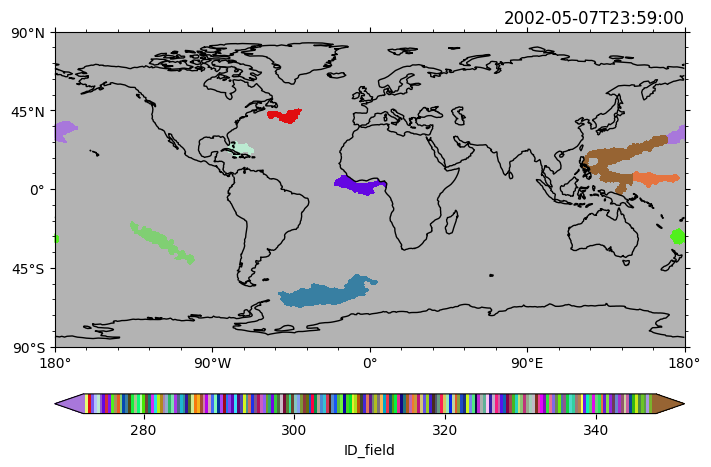

In [38]:
blob_id_field_unique.isel(time=26).pyic.plot(cmap=cmap)

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 454.30 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(<GeoAxes: title={'right': '2002-05-08T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff6a3576380>])

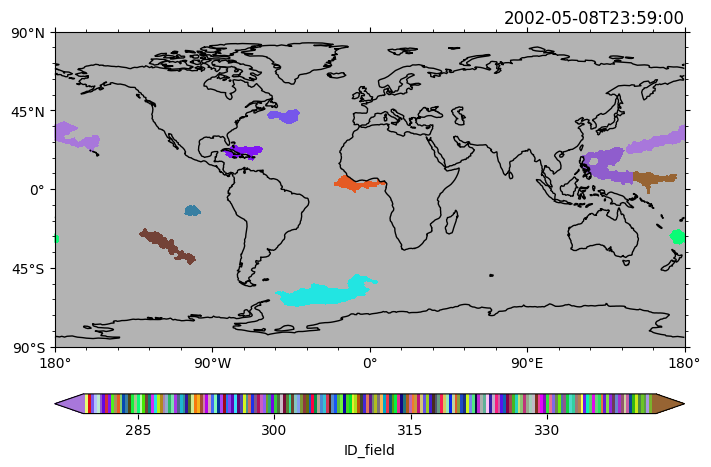

In [44]:
blob_id_field_unique.isel(time=27).pyic.plot(cmap=cmap)

/home/b/b382615/opt/anaconda3/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 454.30 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


(<GeoAxes: title={'right': '2002-05-09T23:59:00'}>,
  <matplotlib.colorbar.Colorbar at 0x7ff6b5051690>])

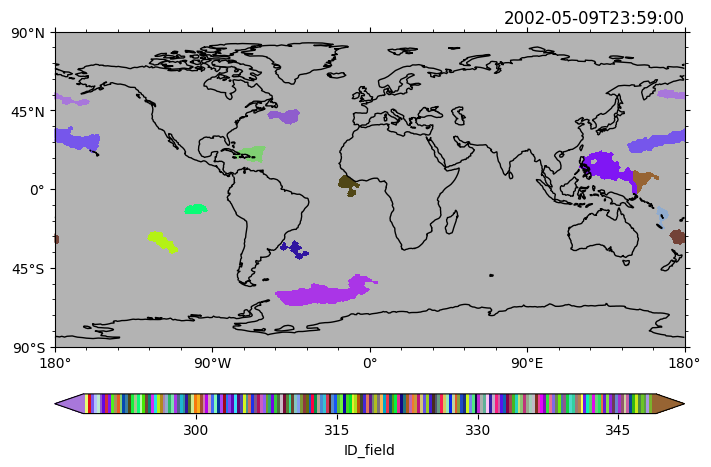

In [45]:
blob_id_field_unique.isel(time=28).pyic.plot(cmap=cmap)

In [ ]:
# Save Tracked Blobs to `zarr` for more efficient parallel I/O

file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'MHWs_tracked_unstruct.zarr'
blobs.to_zarr(file_name, mode='w')